### This is a new version of MLEAP scripts, started in late Aug 2022.
It will combine IProject_MLEAP_ANN and IP_MLEAP script, while improving them.

#### Outline

1. Load libraries and data.
2. pEDA. Look at feature distribution, fix them if they do not look right.
3. Train-test split. Most likely couple years into test set. 2015-2018?. Impute missing values.
4. Transform numerical features, add ohe for inds.
5. Fit xgb as a baseline, then xgb optuna.
6. Fit DL.



In [2]:
# 0. Import libraries #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import os, time, math, re, warnings, random, gc, dill, optuna, pickle, shap
import statsmodels.api as sm
from random import sample

from sklearn.model_selection import train_test_split, KFold, PredefinedSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNetCV
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

plt.style.use('seaborn-white')
warnings.simplefilter(action='ignore')
pd.set_option('display.max_columns', 110)
gc.enable()

In [3]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [4]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [5]:
#min_prd_list = range(100, 676, 25)
min_prd_list = [150, 650]
# min_prd_list = [150, 250, 350, 450, 550, 650]
#min_prd = min_prd_list[0]
windows_width = 3*12
cv_regularizer=0.2
optuna_trials = 20
time0 = time.time()

results = pd.DataFrame(columns = ['min_prd', 'xgbf_train', 'xgbf_val', 'xgbf_test', 
                                  'xgbgs_train', 'xgbgs_val', 'xgbgs_test', 
                                  'xgbo_train', 'xgbo_val', 'xgbo_test'])
results.min_prd = min_prd_list

for min_prd in min_prd_list:

    with open('../input/mleap-46-preprocessed/MLEAP_46_v7.pkl', 'rb') as pickled_one:
        df = pickle.load(pickled_one)
    df = df[df.prd.isin(range(min_prd-1, min_prd+windows_width+10))]
    df_cnt = df.count()
    empty_cols = list(df_cnt[df_cnt<int(df.shape[0]/2)].index)
    df.drop(columns=empty_cols, inplace=True)
    #display(df.shape, df.head(), df.year.describe(), df.count())

    features_miss_dummies = ['amhd', 'BAspr']
    for col in features_miss_dummies:
        if col in df.columns:
            df[col+'_miss'] = df[col].isnull().astype(int)

    temp_cols = ['PERMNO', 'year', 'prd']
    df.reset_index(inplace=True, drop=True)
    X = df.copy()
    y = X.pop('RET')

    train_indx = X.prd<(min_prd+windows_width-1)
    val_indx = X['prd'].isin(range(min_prd+windows_width-1, min_prd+windows_width+2))
    val_indx_extra = X['prd'].isin(range(min_prd+windows_width+5, min_prd+windows_width+8))
    test_indx = X['prd'].isin(range(min_prd+windows_width+2, min_prd+windows_width+5))

    X_train = X[train_indx]
    X_val = X[val_indx]
    X_val_extra = X[val_indx_extra]
    X_test = X[test_indx]
    y_train = y[train_indx]
    y_val = y[val_indx]
    y_val_extra = y[val_indx_extra]
    y_test = y[test_indx]

    #display(X_train.head(3), X_train.tail(3), y_train.head(3), y_train.tail(3))
    display(X_train.shape, X_val.shape, X_test.shape, X_train.prd.describe(), X_val.prd.describe(), X_test.prd.describe())

    X_train.drop(columns=temp_cols, inplace=True)
    X_val.drop(columns=temp_cols, inplace=True)
    X_val_extra.drop(columns=temp_cols, inplace=True)
    X_test.drop(columns=temp_cols, inplace=True)

    #display(X_train.tail())
    col_cat = ['ind']
    col_num = [x for x in X_train.columns if x not in col_cat]
    for col in col_num:
        X_train[col] = X_train[col].fillna(X_train[col].median())
        X_val[col] = X_val[col].fillna(X_train[col].median())
        X_val_extra[col] = X_val_extra[col].fillna(X_train[col].median())
        X_test[col] = X_test[col].fillna(X_train[col].median())
    for col in col_cat:
        X_train[col] = X_train[col].fillna(value=-1000)
        X_val[col] = X_val[col].fillna(value=-1000)
        X_val_extra[col] = X_val_extra[col].fillna(value=-1000)
        X_test[col] = X_test[col].fillna(value=-1000)

    #display(X_train.tail())
    feature_transformer = ColumnTransformer([('num', StandardScaler(), col_num),
                                            ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), col_cat)], 
                                            remainder="passthrough")

    print('Number of features before transformation: ', X_train.shape)
    train_index, val_index, val_index_extra, test_index = X_train.index, X_val.index, X_val_extra.index, X_test.index
    X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
    X_val = pd.DataFrame(feature_transformer.transform(X_val), columns=feature_transformer.get_feature_names_out())
    X_val_extra = pd.DataFrame(feature_transformer.transform(X_val_extra), columns=feature_transformer.get_feature_names_out())
    X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
    print('time to do feature proprocessing: ')
    print('Number of features after transformation: ', X_train.shape, X_val.shape, X_val_extra.shape, X_test.shape)
    X_train.index = train_index
    X_val.index = val_index
    X_val_extra.index = val_index_extra
    X_test.index = test_index
    #display(X_train.tail())

    X = pd.concat([X_train, X_val])
    y = pd.concat([y_train, y_val])
    #display(X,y)

    X_ = pd.concat([X_train, X_val, X_val_extra])
    y_ = pd.concat([y_train, y_val, y_val_extra])
    #display(X,y, X_,y_)

    print('mae of a constant model', mean_absolute_error(df.RET, np.ones(df.shape[0])*(df.RET.mean())))
    print('R2 of a constant model', r2_score(df.RET, np.ones(df.shape[0])*(df.RET.mean())))

    xgb1 = XGBRegressor(tree_method = 'gpu_hist', n_estimators=400, max_depth=4, eta=0.02, colsample_bytree=0.4, subsample=0.6)
    xgb1.fit(X_train, y_train)
    print('fixed XGB train:', mean_absolute_error(y_train, xgb1.predict(X_train)), r2_score(y_train, xgb1.predict(X_train)))
    print('XGB val:', mean_absolute_error(y_val, xgb1.predict(X_val)), r2_score(y_val, xgb1.predict(X_val)))
    print('XGB val extra:', mean_absolute_error(y_val_extra, xgb1.predict(X_val_extra)), r2_score(y_val_extra, xgb1.predict(X_val_extra)))
    print('XGB test:', mean_absolute_error(y_test, xgb1.predict(X_test)), r2_score(y_test, xgb1.predict(X_test)))

    results.loc[results.min_prd==min_prd,'xgbf_train':'xgbf_test'] = \
    [r2_score(y_train, xgb1.predict(X_train)), 
    r2_score(y_val, xgb1.predict(X_val)),
    r2_score(y_test, xgb1.predict(X_test))]

    time1 = time.time()

    # Create a list where train data indices are -1 and validation data indices are 0
    split_index = [-1 if x in X_train.index else 0 for x in X.index]
    pds = PredefinedSplit(test_fold = split_index)

    xgb = XGBRegressor(tree_method = 'gpu_hist')
    param_grid = {'n_estimators':[400, 600, 800], 'max_depth':[2,3,4,5], 'eta':[0.006, 0.012, 0.02], 
                  'subsample':[0.6], 'colsample_bytree':[0.6]}
    xgbgs = GridSearchCV(estimator = xgb, cv=pds, param_grid=param_grid)

    # Fit with all data
    xgbgs.fit(X_, y_)

    print('gs XGB', xgbgs.best_params_, xgbgs.best_score_, time.time()-time1)
    print('XGB train:', mean_absolute_error(y_train, xgbgs.predict(X_train)), r2_score(y_train, xgbgs.predict(X_train)))
    print('XGB validation:', mean_absolute_error(y_val, xgbgs.predict(X_val)), r2_score(y_val, xgbgs.predict(X_val)))
    print('XGB validation extra:', mean_absolute_error(y_val_extra, xgbgs.predict(X_val_extra)), r2_score(y_val_extra, xgbgs.predict(X_val_extra)))
    print('XGB test:', mean_absolute_error(y_test, xgbgs.predict(X_test)), r2_score(y_test, xgbgs.predict(X_test)))

    results.loc[results.min_prd==min_prd,'xgbgs_train':'xgbgs_test'] = \
    [r2_score(y_train, xgbgs.predict(X_train)), 
    r2_score(y_val, xgbgs.predict(X_val)),
    r2_score(y_test, xgbgs.predict(X_test))]

    time1 = time.time()
    def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1):

        params = {
        "tree_method": 'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "n_estimators": trial.suggest_int("n_estimators", 800, 1500),
        "max_depth": trial.suggest_int("max_depth", 2, 6),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.0005, 0.03),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.05, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.1, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 50.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 500.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 100.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 50)    }

        model = XGBRegressor(**params, njobs=-1)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose = False)

        score_train = r2_score(y_train, model.predict(X_train))
        score_val = r2_score(y_val, model.predict(X_val))
        score_val_extra = r2_score(y_val_extra, model.predict(X_val_extra)) 
        score_val = (score_val+score_val_extra)/2
        overfit = np.abs(score_train-score_val)

        return score_val-cv_regularizer*overfit


    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=optuna_trials)
    print('Total time for hypermarameter optimization ', time.time()-time1)
    hp = study.best_params
    for key, value in hp.items():
        print(f"{key:>20s} : {value}")
    print(f"{'best objective value':>20s} : {study.best_value}")
    optuna_hyperpars = study.best_params
    optuna_hyperpars['tree_method']='gpu_hist'
    optuna_xgb = XGBRegressor(**optuna_hyperpars)
    optuna_xgb.fit(X, y)
    print('Optuna XGB train: \n', 
          mean_absolute_error(y_train, optuna_xgb.predict(X_train)), r2_score(y_train, optuna_xgb.predict(X_train)), '\nvalidation \n',
          mean_absolute_error(y_val, optuna_xgb.predict(X_val)), r2_score(y_val, optuna_xgb.predict(X_val)),
          mean_absolute_error(y_val_extra, optuna_xgb.predict(X_val_extra)), r2_score(y_val_extra, optuna_xgb.predict(X_val_extra)), '\ntest \n',
          mean_absolute_error(y_test, optuna_xgb.predict(X_test)), r2_score(y_test, optuna_xgb.predict(X_test)))

    results.loc[results.min_prd==min_prd,'xgbo_train':'xgbo_test'] = \
    [r2_score(y_train, optuna_xgb.predict(X_train)), 
    r2_score(y_val, optuna_xgb.predict(X_val)),
    r2_score(y_test, optuna_xgb.predict(X_test))]

    display(results)

(46500, 41)

(4444, 41)

(4403, 41)

count    46500.000000
mean       167.403097
std         10.350122
min        149.000000
25%        159.000000
50%        168.000000
75%        176.000000
max        184.000000
Name: prd, dtype: float64

count    4444.000000
mean      185.997525
std         0.816079
min       185.000000
25%       185.000000
50%       186.000000
75%       187.000000
max       187.000000
Name: prd, dtype: float64

count    4403.000000
mean      188.997956
std         0.818208
min       188.000000
25%       188.000000
50%       189.000000
75%       190.000000
max       190.000000
Name: prd, dtype: float64

Number of features before transformation:  (46500, 38)
time to do feature proprocessing: 
Number of features after transformation:  (46500, 84) (4444, 84) (4381, 84) (4403, 84)
mae of a constant model 7.989002798117338
R2 of a constant model 0.0
fixed XGB train: 7.2936517680386475 0.08209972933431675
XGB val: 9.333257547436476 0.021046069322619876
XGB val extra: 7.449474573984752 0.005638548266455157
XGB test: 10.509277917328513 0.026280919917970325
gs XGB {'colsample_bytree': 0.6, 'eta': 0.012, 'max_depth': 5, 'n_estimators': 600, 'subsample': 0.6} 0.025436589972033352 52.95054602622986
XGB train: 7.241671823627634 0.09783003114377553
XGB validation: 8.837739464119451 0.1338705926983017
XGB validation extra: 6.983415793741495 0.1367766827196445
XGB test: 10.455126096822962 0.03312929656455288


[I 2022-09-07 00:57:51,154] A new study created in memory with name: no-name-3cb446f1-e5f3-469a-a894-c2321b6e4a8f
[I 2022-09-07 00:57:55,484] Trial 0 finished with value: 0.0010487315872245162 and parameters: {'n_estimators': 853, 'max_depth': 5, 'learning_rate': 0.005554481208627272, 'colsample_bytree': 0.8356093575921506, 'subsample': 0.5432061652329488, 'alpha': 0.11533951508784888, 'lambda': 0.27538060266325076, 'gamma': 0.029340729898137585, 'min_child_weight': 12.736503737730905}. Best is trial 0 with value: 0.0010487315872245162.
[I 2022-09-07 00:57:58,201] Trial 1 finished with value: 0.008413727532025784 and parameters: {'n_estimators': 1073, 'max_depth': 3, 'learning_rate': 0.007602155679306577, 'colsample_bytree': 0.3615664373117418, 'subsample': 0.7898778548776517, 'alpha': 0.10416280011392451, 'lambda': 367.9752670653509, 'gamma': 2.50851441150189, 'min_child_weight': 3.814335181119885}. Best is trial 1 with value: 0.008413727532025784.
[I 2022-09-07 00:57:59,642] Trial 2 

Total time for hypermarameter optimization  48.010602712631226
        n_estimators : 1421
           max_depth : 3
       learning_rate : 0.01268081997781313
    colsample_bytree : 0.05541138494360648
           subsample : 0.9462953760536352
               alpha : 8.034813552010322
              lambda : 1.9184398294778817
               gamma : 1.132840789369327e-10
    min_child_weight : 2.174942112625565
best objective value : 0.015650065512771795
Optuna XGB train: 
 7.381897176222274 0.05315860154502827 
validation 
 9.101018980041395 0.07279894790320474 7.3289798045213175 0.02752500726740692 
test 
 10.489568024623782 0.022449379332751596


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test
0,150,0.0821,0.021046,0.026281,0.09783,0.133871,0.033129,0.053159,0.072799,0.022449
1,650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(61151, 47)

(4761, 47)

(4706, 47)

count    61151.000000
mean       666.117741
std         10.398283
min        649.000000
25%        657.000000
50%        666.000000
75%        675.000000
max        684.000000
Name: prd, dtype: float64

count    4761.000000
mean      685.998110
std         0.817223
min       685.000000
25%       685.000000
50%       686.000000
75%       687.000000
max       687.000000
Name: prd, dtype: float64

count    4706.000000
mean      688.997025
std         0.816925
min       688.000000
25%       688.000000
50%       689.000000
75%       690.000000
max       690.000000
Name: prd, dtype: float64

Number of features before transformation:  (61151, 44)
time to do feature proprocessing: 
Number of features after transformation:  (61151, 92) (4761, 92) (4635, 92) (4706, 92)
mae of a constant model 7.991024255095651
R2 of a constant model 0.0
fixed XGB train: 7.37186159053143 0.09370125511856164
XGB val: 7.769372845620342 0.1202960492766123
XGB val extra: 8.716766312159114 0.08044960563574766
XGB test: 8.464771770272549 0.04196543276367293
gs XGB {'colsample_bytree': 0.6, 'eta': 0.02, 'max_depth': 2, 'n_estimators': 600, 'subsample': 0.6} 0.13082812132204125 56.8817253112793
XGB train: 7.487009718437392 0.05510111043575783
XGB validation: 7.5185901740389 0.18438306180043718
XGB validation extra: 8.477010479339 0.12992120563495957
XGB test: 8.439680663549156 0.040450396213600026


[I 2022-09-07 00:59:45,575] A new study created in memory with name: no-name-00b7c1bb-7a28-4aa7-bfce-3e30ef677db0
[I 2022-09-07 00:59:47,274] Trial 0 finished with value: 0.09552727433179534 and parameters: {'n_estimators': 1079, 'max_depth': 2, 'learning_rate': 0.022306589642374277, 'colsample_bytree': 0.2087114430326722, 'subsample': 0.22079721447293946, 'alpha': 2.1537998766884425, 'lambda': 0.7280692638370136, 'gamma': 23.968358783137713, 'min_child_weight': 23.734630833507307}. Best is trial 0 with value: 0.09552727433179534.
[I 2022-09-07 00:59:48,850] Trial 1 finished with value: 0.10065358924134826 and parameters: {'n_estimators': 1264, 'max_depth': 4, 'learning_rate': 0.0191275865237689, 'colsample_bytree': 0.8319032492890219, 'subsample': 0.4297256476710566, 'alpha': 0.12715188972160768, 'lambda': 1.0836208339092357, 'gamma': 0.0060436591170761195, 'min_child_weight': 6.909891770856923}. Best is trial 1 with value: 0.10065358924134826.
[I 2022-09-07 00:59:50,881] Trial 2 fini

Total time for hypermarameter optimization  52.966289043426514
        n_estimators : 1477
           max_depth : 3
       learning_rate : 0.019754948141593447
    colsample_bytree : 0.41611119613442266
           subsample : 0.7072906632446987
               alpha : 0.1415753949568421
              lambda : 8.888077381572515
               gamma : 8.57776528027647e-09
    min_child_weight : 1.7911947788279619
best objective value : 0.10392983759138345
Optuna XGB train: 
 7.315122797851029 0.10856201100958718 
validation 
 7.341674486916245 0.23359373160350327 8.583436137056328 0.10202295985186882 
test 
 8.452829179435007 0.037441996330436655


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test
0,150,0.0821,0.021046,0.026281,0.09783,0.133871,0.033129,0.053159,0.072799,0.022449
1,650,0.093701,0.120296,0.041965,0.055101,0.184383,0.04045,0.108562,0.233594,0.037442


In [6]:
display(results.iloc[:,1:].mean())
# cv_regularizer = 0.5
# optuna_trials = 80
print(time.time()-time0)

xgbf_train     0.087900
xgbf_val       0.070671
xgbf_test      0.034123
xgbgs_train    0.076466
xgbgs_val      0.159127
xgbgs_test     0.036790
xgbo_train     0.080860
xgbo_val       0.153196
xgbo_test      0.029946
dtype: float64

237.29979705810547


In [7]:
# general point:
# compared to NN, xgb is harder to regularize
# in NN, you can simply shrink coefficient towards constant prediction.
# in xgb, you can not do that. the only way to regularize is via hyperparameters.
# in other words, by tweaking hyperpars, in NN you can approach R^2=0.0 prediction from a constant model arbitrarily close
# in xgb, you can not do that.
# by setting eta as low as 0.1% you can bring r2 down to 0.1%, but lowering eta further actyally increases abs(r2).


In [8]:
optuna_xgb

XGBRegressor(alpha=0.1415753949568421, base_score=0.5, booster='gbtree',
             callbacks=None, colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.41611119613442266, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             gamma=8.57776528027647e-09, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             lambda=8.888077381572515, learning_rate=0.019754948141593447,
             max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=3,
             max_leaves=0, min_child_weight=1.7911947788279619, missing=nan,
             monotone_constraints='()', n_estimators=1477, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

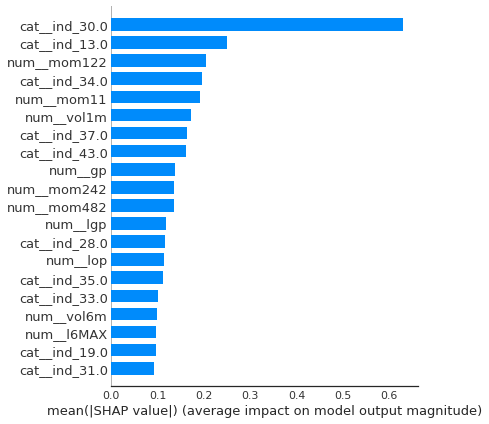

In [9]:
explainerxgbc = shap.TreeExplainer(optuna_xgb)
shap_values_XGBoost_test = explainerxgbc.shap_values(X_test)

vals = np.abs(shap_values_XGBoost_test).mean(0)
feature_names = X_test.columns
feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                 columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                              ascending=False, inplace=True)

shap.summary_plot(shap_values_XGBoost_test, X_test, 
                  plot_type="bar", plot_size=(6,6), max_display=20)

In [10]:
# Evaluate performance of XGB models:
r2_xgb1 = r2_score(y_test, xgb1.predict(X_test))
r2_xgbgs = r2_score(y_test, xgbgs.predict(X_test))
r2_xgbo = r2_score(y_test, optuna_xgb.predict(X_test))

print('Min_prd: ', min_prd)
print('Constant guess: ', mean_absolute_error(y_test, np.ones(len(y_test))*y_test.mean()), 
      r2_score(y_test, np.ones(len(y_test))*y_test.mean()))
print('XGB test:', mean_absolute_error(y_test, xgb1.predict(X_test)), r2_xgb1)
print('XGB GS test:', mean_absolute_error(y_test, xgbgs.predict(X_test)), r2_xgbgs)
print('Optuna XGB test:', mean_absolute_error(y_test, optuna_xgb.predict(X_test)), r2_xgbo)


Min_prd:  650
Constant guess:  8.70343870957194 0.0
XGB test: 8.464771770272549 0.04196543276367293
XGB GS test: 8.439680663549156 0.040450396213600026
Optuna XGB test: 8.452829179435007 0.037441996330436655


In [11]:
print('Total time for a script: ', time.time()-time0)

Total time for a script:  238.5843210220337


In [12]:
results.iloc[:,1:].mean()

xgbf_train     0.087900
xgbf_val       0.070671
xgbf_test      0.034123
xgbgs_train    0.076466
xgbgs_val      0.159127
xgbgs_test     0.036790
xgbo_train     0.080860
xgbo_val       0.153196
xgbo_test      0.029946
dtype: float64

In [13]:
# 3yr window, trials=20, cv_reg=0.03: 0.88%. runs 1 hr.
# 3yr, t=40, cv_reg=0.04: 0.96%.



In [14]:
display(X_train, X_val, X_test)

,num__mom482,num__mom242,num__bm,num__op,num__gp,num__inv,num__mom11,num__mom122,num__amhd,num__ivol_capm,num__ivol_ff5,num__beta_bw,num__MAX,num__vol1m,num__vol6m,num__vol12m,num__BAspr,num__size,num__lbm,num__lop,num__lgp,num__linv,num__llme,num__l1amhd,num__l1MAX,num__l1BAspr,num__l3amhd,num__l3MAX,num__l3BAspr,num__l6amhd,num__l6MAX,num__l6BAspr,num__l12amhd,num__l12MAX,num__l12BAspr,num__l12mom122,num__l12ivol_capm,num__l12ivol_ff5,num__l12beta_bw,num__l12vol6m,num__l12vol12m,num__amhd_miss,num__BAspr_miss,cat__ind_1.0,cat__ind_2.0,cat__ind_3.0,cat__ind_4.0,cat__ind_5.0,cat__ind_6.0,cat__ind_7.0,cat__ind_8.0,cat__ind_9.0,cat__ind_10.0,cat__ind_11.0,cat__ind_12.0,cat__ind_13.0,cat__ind_14.0,cat__ind_15.0,cat__ind_16.0,cat__ind_17.0,cat__ind_18.0,cat__ind_19.0,cat__ind_20.0,cat__ind_21.0,cat__ind_22.0,cat__ind_23.0,cat__ind_24.0,cat__ind_25.0,cat__ind_26.0,cat__ind_27.0,cat__ind_28.0,cat__ind_29.0,cat__ind_30.0,cat__ind_31.0,cat__ind_32.0,cat__ind_33.0,cat__ind_34.0,cat__ind_35.0,cat__ind_36.0,cat__ind_37.0,cat__ind_38.0,cat__ind_39.0,cat__ind_40.0,cat__ind_41.0,cat__ind_42.0,cat__ind_43.0,cat__ind_44.0,cat__ind_45.0,cat__ind_46.0,cat__ind_47.0,cat__ind_48.0,cat__ind_49.0
0,-0.500811,0.216499,-0.340384,-0.328582,0.045307,-0.588233,-0.093832,0.000390,0.618694,-0.598732,-0.668599,-0.045083,-0.636752,-0.547769,-0.197902,-0.146483,-0.138587,-0.629521,-0.541304,0.771667,0.622910,-0.842829,-0.604599,0.619048,-0.539101,-0.162381,0.640642,-0.255652,-0.064216,0.663339,0.842260,-0.043732,0.610264,-0.539101,-0.158755,-0.190705,-0.419162,-0.318870,0.700359,-0.292789,-0.036506,-0.150249,-0.037746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.160589,0.161776,-0.340384,-0.328582,0.045307,-0.588233,-0.209729,-0.031615,0.581445,-0.907245,-0.887352,-0.147561,-0.930676,-1.012115,-0.545421,-0.204533,-0.016439,-0.634032,-0.541304,0.771667,0.622910,-0.842829,-0.598933,0.613128,-0.640300,-0.139207,0.636029,-0.350676,-0.080901,0.654569,0.985874,-0.104737,0.628126,-0.640300,-0.037412,0.150876,-0.712379,-0.660494,0.536133,-0.415928,-0.223150,-0.150249,-0.037746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.575119,0.265471,-0.282249,-0.211330,-0.007926,0.443927,2.504443,0.095002,0.569546,-0.379325,-0.203368,-0.209169,0.164629,-0.553321,-0.751682,-0.206327,-0.326794,-0.527200,-0.378242,-0.328445,0.040105,-0.591069,-0.622427,0.575878,-0.934985,-0.017309,0.607452,-0.544536,-0.163588,0.647515,0.815119,-0.037338,0.630172,-0.934985,-0.219313,0.357740,-0.192800,-0.119984,0.589740,-0.395724,-0.341288,-0.150249,-0.037746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.815074,0.890410,-0.282249,-0.211330,-0.007926,0.443927,0.677506,1.240795,0.551723,-0.785948,-0.791334,-0.258246,-0.498815,-0.926922,-0.837305,-0.233204,-0.016652,-0.491969,-0.378242,-0.328445,0.040105,-0.591069,-0.709632,0.563978,0.163157,-0.327029,0.601532,-0.646577,-0.140418,0.623360,-0.296632,-0.073990,0.633321,0.163157,-0.178803,-0.361082,-0.647774,-0.732243,0.731954,-0.485705,-0.355413,-0.150249,-0.037746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.933095,1.326763,-0.282249,-0.211330,-0.007926,0.443927,0.606145,1.563619,0.520774,-0.657968,-0.637011,-0.108027,-0.202545,-0.731773,-0.912226,-0.371910,-0.187430,-0.460080,-0.378242,-0.328445,0.040105,-0.591069,-0.707738,0.546154,-0.502006,-0.017522,0.564280,-0.943714,-0.018536,0.618745,-0.390212,-0.090278,0.639270,-0.502006,0.030898,-0.00843

,num__mom482,num__mom242,num__bm,num__op,num__gp,num__inv,num__mom11,num__mom122,num__amhd,num__ivol_capm,num__ivol_ff5,num__beta_bw,num__MAX,num__vol1m,num__vol6m,num__vol12m,num__BAspr,num__size,num__lbm,num__lop,num__lgp,num__linv,num__llme,num__l1amhd,num__l1MAX,num__l1BAspr,num__l3amhd,num__l3MAX,num__l3BAspr,num__l6amhd,num__l6MAX,num__l6BAspr,num__l12amhd,num__l12MAX,num__l12BAspr,num__l12mom122,num__l12ivol_capm,num__l12ivol_ff5,num__l12beta_bw,num__l12vol6m,num__l12vol12m,num__amhd_miss,num__BAspr_miss,cat__ind_1.0,cat__ind_2.0,cat__ind_3.0,cat__ind_4.0,cat__ind_5.0,cat__ind_6.0,cat__ind_7.0,cat__ind_8.0,cat__ind_9.0,cat__ind_10.0,cat__ind_11.0,cat__ind_12.0,cat__ind_13.0,cat__ind_14.0,cat__ind_15.0,cat__ind_16.0,cat__ind_17.0,cat__ind_18.0,cat__ind_19.0,cat__ind_20.0,cat__ind_21.0,cat__ind_22.0,cat__ind_23.0,cat__ind_24.0,cat__ind_25.0,cat__ind_26.0,cat__ind_27.0,cat__ind_28.0,cat__ind_29.0,cat__ind_30.0,cat__ind_31.0,cat__ind_32.0,cat__ind_33.0,cat__ind_34.0,cat__ind_35.0,cat__ind_36.0,cat__ind_37.0,cat__ind_38.0,cat__ind_39.0,cat__ind_40.0,cat__ind_41.0,cat__ind_42.0,cat__ind_43.0,cat__ind_44.0,cat__ind_45.0,cat__ind_46.0,cat__ind_47.0,cat__ind_48.0,cat__ind_49.0
36,0.017571,-1.255213,-0.369900,-0.031204,0.115022,-0.006492,-1.009764,1.071891,0.479974,-0.180693,-0.157000,-0.183768,-0.515268,-0.347572,-0.228553,-0.208170,0.023861,-0.498862,-0.729077,0.419892,0.520345,-0.288298,-0.617712,0.454084,0.465902,0.021436,0.400562,-0.237429,0.423626,0.288105,0.777438,-0.126923,-0.008636,0.465902,-0.115740,-1.740134,-0.637351,-0.715329,-0.585179,-0.413230,-0.080031,-0.150249,-0.037746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,-0.122740,-1.136954,-0.369900,-0.031204,0.115022,-0.006492,-0.125082,1.144146,0.498559,-0.659567,-0.713933,-0.249618,-0.733894,-0.690161,-0.241237,-0.218720,0.393677,-0.499506,-0.729077,0.419892,0.520345,-0.288298,-0.669699,0.474402,-0.518501,0.022908,0.423160,-0.359081,0.048667,0.334052,-0.811733,0.131124,0.015623,-0.518501,-0.056377,-1.882481,-0.675613,-0.722268,-0.659664,-0.425989,-0.088143,-0.150249,-0.037746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.226189,-1.110995,-0.780439,-0.481518,-0.095930,-0.717797,0.923598,0.774266,0.513240,-0.270934,-0.273592,-0.453558,-0.282635,-0.394608,-0.291224,-0.355168,0.272001,-0.454238,-0.408215,-0.033124,0.109300,-0.026699,-0.627657,0.492988,-0.737694,0.391967,0.442480,0.468830,0.020204,0.363010,0.066329,0.163772,0.089343,-0.737694,-0.008474,-1.877967,0.774472,0.782417,-0.208721,-0.238738,-0.195021,-0.150249,-0.037746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64,-0.152043,-0.096694,-0.344948,-1.067199,1.968471,-0.689230,-2.351983,-1.349284,2.068987,3.883441,3.748632,-2.415869,0.749706,4.022481,2.049071,1.584084,2.188332,-2.319097,-1.115141,-0.143111,2.377806,-0.732182,-1.551684,2.063489,0.123108,1.834347,2.051957,-0.335407,1.603946,2.024413,2.226897,0.104445,1.995707,0.123108,-0.092068,-0.910604,1.110320,1.169139,-2.729320,0.660596,-0.216356,-0.150249,-0.037746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65,-0.152043,-0.096694,-0.278284,-1.027436,1.432911,-1.591683,1.057888,-2.066496,2.068987,4.081030,3.979960,-2.406530,3.994730,4.122402,2.794204,2.031846,3.064452,-2.268268,-0.382877,-1.061952,1.948956,-0.689050,-1.701090,2.063489,0.749748,2.182949,2.051957,1.405445,2.491250,2.035117,0.059071,1.725945,1.993128,0.749748,1.335923,-1.223386,0.524419,0.467423,

,num__mom482,num__mom242,num__bm,num__op,num__gp,num__inv,num__mom11,num__mom122,num__amhd,num__ivol_capm,num__ivol_ff5,num__beta_bw,num__MAX,num__vol1m,num__vol6m,num__vol12m,num__BAspr,num__size,num__lbm,num__lop,num__lgp,num__linv,num__llme,num__l1amhd,num__l1MAX,num__l1BAspr,num__l3amhd,num__l3MAX,num__l3BAspr,num__l6amhd,num__l6MAX,num__l6BAspr,num__l12amhd,num__l12MAX,num__l12BAspr,num__l12mom122,num__l12ivol_capm,num__l12ivol_ff5,num__l12beta_bw,num__l12vol6m,num__l12vol12m,num__amhd_miss,num__BAspr_miss,cat__ind_1.0,cat__ind_2.0,cat__ind_3.0,cat__ind_4.0,cat__ind_5.0,cat__ind_6.0,cat__ind_7.0,cat__ind_8.0,cat__ind_9.0,cat__ind_10.0,cat__ind_11.0,cat__ind_12.0,cat__ind_13.0,cat__ind_14.0,cat__ind_15.0,cat__ind_16.0,cat__ind_17.0,cat__ind_18.0,cat__ind_19.0,cat__ind_20.0,cat__ind_21.0,cat__ind_22.0,cat__ind_23.0,cat__ind_24.0,cat__ind_25.0,cat__ind_26.0,cat__ind_27.0,cat__ind_28.0,cat__ind_29.0,cat__ind_30.0,cat__ind_31.0,cat__ind_32.0,cat__ind_33.0,cat__ind_34.0,cat__ind_35.0,cat__ind_36.0,cat__ind_37.0,cat__ind_38.0,cat__ind_39.0,cat__ind_40.0,cat__ind_41.0,cat__ind_42.0,cat__ind_43.0,cat__ind_44.0,cat__ind_45.0,cat__ind_46.0,cat__ind_47.0,cat__ind_48.0,cat__ind_49.0
39,0.114148,-1.221555,-0.780439,-0.481518,-0.095930,-0.717797,-1.353610,0.558254,0.508204,0.601670,0.549860,-0.591416,-0.560881,0.497645,-0.175013,-0.312837,0.062075,-0.515229,-0.408215,-0.033124,0.109300,-0.026699,-0.554833,0.507669,-0.285266,0.270540,0.462800,-0.523765,0.021676,0.383204,-0.278687,0.402250,0.123209,-0.285266,0.089480,-1.868365,-0.023381,0.075125,-0.135822,-0.198262,-0.118275,-0.150249,-0.037746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,0.708016,-1.025009,-0.780439,-0.481518,-0.095930,-0.717797,1.152138,-0.015554,0.507482,-0.108999,-0.048967,-0.709727,-0.369716,-0.133699,-0.133880,-0.258084,-0.302480,-0.460535,-0.408215,-0.033124,0.109300,-0.026699,-0.536835,0.502633,-0.564232,0.061044,0.481386,-0.744781,0.390686,0.405810,-0.398489,0.036208,0.140100,-0.564232,-0.168442,-1.636608,-0.900703,-0.812385,-0.243596,-0.272191,-0.142440,-0.150249,-0.037746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41,0.588727,-0.674185,-0.780439,-0.481518,-0.095930,-0.717797,0.418507,0.782500,0.494919,0.960556,0.585115,-0.504172,0.612468,1.194725,-0.004759,-0.119211,-0.183760,-0.436810,-0.408215,-0.033124,0.109300,-0.026699,-0.589087,0.501912,-0.372573,-0.302765,0.496068,-0.288589,0.269276,0.425136,0.416838,0.008422,0.199132,-0.372573,-0.298296,-1.508436,-0.009298,-0.138327,-0.299628,-0.377692,-0.411109,-0.150249,-0.037746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66,-0.152043,-0.096694,-0.278284,-1.027436,1.432911,-1.591683,-1.606161,-2.066496,2.068987,3.950431,4.096534,-2.445455,3.087190,3.635682,3.184424,2.267580,1.472282,-2.342709,-0.382877,-1.061952,1.948956,-0.689050,-1.673135,2.063489,4.003177,3.057275,2.051957,0.123184,1.832875,2.035117,0.544967,0.485602,1.996417,4.003177,0.931388,-1.302168,1.504758,1.765495,-1.753375,0.752070,-0.216356,-0.150249,-0.037746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67,-0.152043,-0.096694,-0.278284,-1.027436,1.432911,-1.591683,-2.351983,-2.066496,2.068987,2.766578,3.128399,-2.053542,1.291341,2.582623,3.415948,2.403138,8.340880,-2.504108,-0.382877,-1.061952,1.948956,-0.689050,-1.700324,2.063489,3.093286,1.468365,2.051957,0.755039,2.181432,2.035117,-0.375175,1.554498,1.996417,3.093286,2.697698,-1.576470,0.892243,0.948094

In [15]:
neurons_base = 16
dropout_rate = 0.05
# n_b=8 was ok with small overfit.
# n_b=32 starts clearly overfitting. 
# 128 fits clearly slower than 64 and becomes somewhat unstable. regularization could make it work, but i see no reason to go wider.
# 64 seems to have nice balance of flexibility and runtime, but its variance may be too large. dropout makes variance vene worse.
# 6 hidden layers is probably most this architecture can hold

# in this framework the optimal model seems to have width of 16 or 32, somehow regularized. try l1/l2?
# w32 can take at most 0.03 dropout.
# w16 looks good w/o dropout.

# more general point:
# main drawback of dropout is in incresing variance
# for textbook problems with high s/n ratio (e.g., mnist) this may be ok.
# for application like this with very low s/n ratio dropout may be a bad idea.

model_snn = Sequential([
    tf.keras.layers.Dense(units=neurons_base*32, activation="selu", kernel_initializer="lecun_normal", input_shape=X_train.shape[1:]),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*16, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*8, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    Dense(1)])

print(model_snn.count_params())

2022-09-07 01:00:46.425597: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 01:00:46.426970: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 01:00:46.427667: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 01:00:46.428536: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

222721


ead from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 01:00:53.963302: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14637 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [16]:
neurons_base = 32
dropout_rate = 0.25

model_snn = Sequential([
    tf.keras.layers.Dense(units=neurons_base*8, activation="selu", kernel_initializer="lecun_normal", input_shape=X_train.shape[1:]),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    Dense(1)])

print(model_snn.count_params())

# similar problem as before: model seems ok in terms of flexibility and variance, but adding dropout breaks it before i can fix overfitting.
# the solution is to either use smaller models or to use laternative regularizers (which do not increase variance.)

67073


In [17]:
neurons_base = 6
l2_reg_rate = 0.2

model_snn = Sequential([
    tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                          kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate), input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    Dense(1)])

print(model_snn.count_params())

3247


In [18]:
neurons_base = 8
l2_reg_rate = 0.2

model_snn = Sequential([
    tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                          kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate), input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(units=neurons_base*3, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),

    Dense(1)])

print(model_snn.count_params())

4657


In [95]:
neurons_base = 8
l2_reg_rate = 0.3

model_snn = Sequential([
    tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                          kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate), input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    Dense(1)])

print(model_snn.count_params())

# snn: 32-16-8-4 with 30%l2 reg seems to converge to 5.1% test r2.

3681


Epoch 1/1000
30/30 - 1s - loss: 139.9440 - mean_squared_error: 123.9719 - val_loss: 150.7428 - val_mean_squared_error: 136.6830
Epoch 2/1000
30/30 - 0s - loss: 135.5417 - mean_squared_error: 123.0081 - val_loss: 147.0118 - val_mean_squared_error: 135.9563
Epoch 3/1000
30/30 - 0s - loss: 132.5221 - mean_squared_error: 122.5378 - val_loss: 144.0993 - val_mean_squared_error: 135.1556
Epoch 4/1000
30/30 - 0s - loss: 130.1232 - mean_squared_error: 121.9219 - val_loss: 141.9333 - val_mean_squared_error: 134.4223
Epoch 5/1000
30/30 - 0s - loss: 128.1767 - mean_squared_error: 121.1550 - val_loss: 138.5352 - val_mean_squared_error: 131.9656
Epoch 6/1000
30/30 - 0s - loss: 126.7361 - mean_squared_error: 120.5175 - val_loss: 138.7566 - val_mean_squared_error: 132.9056
Epoch 7/1000
30/30 - 0s - loss: 125.7207 - mean_squared_error: 120.1480 - val_loss: 136.9989 - val_mean_squared_error: 131.7204
Epoch 8/1000
30/30 - 0s - loss: 124.8485 - mean_squared_error: 119.8273 - val_loss: 137.1170 - val_mean_

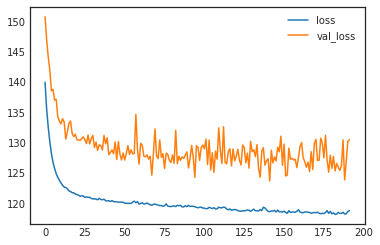

In [96]:
early_stopping50 = EarlyStopping(patience=50, restore_best_weights=True)
time1 = time.time()
optimizer_adam = tf.keras.optimizers.Adam()
model_snn.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
history = model_snn.fit(X_train, y_train, validation_data=(X_val, y_val), 
                         batch_size=2048, epochs=1000, verbose=2, callbacks=[early_stopping50])
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

print([r2_score(y_train, model_snn.predict(X_train)), 
       r2_score(y_val, model_snn.predict(X_val)),
       r2_score(y_test, model_snn.predict(X_test))])
print(time.time()-time1)

In [ ]:
X_train.skew()

In [ ]:
X_val

In [ ]:
# on nns:
# - try classic regularizers (l1, l2 etc)
# - try different architecture (not snnn)
# classic architecture:
# He initialization, elu activation, batch norm, l2 reg, adam.

# - try exotic architecture, e.g., wide'n'deep
# 


In [71]:
# classic architecture:

neurons_base = 16
l2_reg_rate = 0.4
he_init = tf.keras.initializers.HeNormal()

model_nn = Sequential([
    tf.keras.layers.Dense(units=neurons_base*8, activation="elu", kernel_initializer=he_init, 
                          kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate), input_shape=X_train.shape[1:]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=neurons_base*4, activation="elu", kernel_initializer=he_init,
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.BatchNormalization(),    
    tf.keras.layers.Dense(units=neurons_base*2, activation="elu", kernel_initializer=he_init,
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.BatchNormalization(),    
    tf.keras.layers.Dense(units=neurons_base, activation="elu", kernel_initializer=he_init,
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(1)])

print(model_nn.count_params())


23681


Epoch 1/1000
30/30 - 2s - loss: 292.9427 - mean_squared_error: 123.7774 - val_loss: 280.9637 - val_mean_squared_error: 135.7735
Epoch 2/1000
30/30 - 0s - loss: 248.7766 - mean_squared_error: 122.1955 - val_loss: 244.3598 - val_mean_squared_error: 135.9327
Epoch 3/1000
30/30 - 0s - loss: 215.8054 - mean_squared_error: 120.9648 - val_loss: 218.1856 - val_mean_squared_error: 136.4254
Epoch 4/1000
30/30 - 0s - loss: 191.6477 - mean_squared_error: 119.5777 - val_loss: 199.5424 - val_mean_squared_error: 136.8327
Epoch 5/1000
30/30 - 0s - loss: 174.6854 - mean_squared_error: 118.9356 - val_loss: 184.2599 - val_mean_squared_error: 135.2799
Epoch 6/1000
30/30 - 0s - loss: 162.2748 - mean_squared_error: 118.3630 - val_loss: 175.2728 - val_mean_squared_error: 136.3410
Epoch 7/1000
30/30 - 0s - loss: 152.9210 - mean_squared_error: 117.8156 - val_loss: 168.7839 - val_mean_squared_error: 137.4088
Epoch 8/1000
30/30 - 0s - loss: 146.7896 - mean_squared_error: 118.1870 - val_loss: 160.7534 - val_mean_

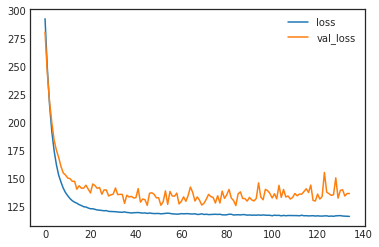

In [72]:
early_stopping50 = EarlyStopping(patience=50, restore_best_weights=True)
time1 = time.time()
optimizer_adam = tf.keras.optimizers.Adam()
model_nn.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
history = model_nn.fit(X_train, y_train, validation_data=(X_val, y_val), 
                         batch_size=2048, epochs=1000, verbose=2, callbacks=[early_stopping50])
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

print([r2_score(y_train, model_nn.predict(X_train)), 
       r2_score(y_val, model_nn.predict(X_val)),
       r2_score(y_test, model_nn.predict(X_test))])
print(time.time()-time1)